<a href="https://colab.research.google.com/github/harpreetahluwalia/Deep-Forecast/blob/master/multiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [ ]:
import keras as keras
tf.__version__

'2.9.2'

In [ ]:
!tf_upgrade_v2 -h

usage: tf_upgrade_v2 [-h] [--infile INPUT_FILE] [--outfile OUTPUT_FILE]
                     [--intree INPUT_TREE] [--outtree OUTPUT_TREE]
                     [--copyotherfiles COPY_OTHER_FILES] [--inplace]
                     [--no_import_rename] [--no_upgrade_compat_v1_import]
                     [--reportfile REPORT_FILENAME] [--mode {DEFAULT,SAFETY}]
                     [--print_all]

Convert a TensorFlow Python file from 1.x to 2.0

Simple usage:
  tf_upgrade_v2.py --infile foo.py --outfile bar.py
  tf_upgrade_v2.py --infile foo.ipynb --outfile bar.ipynb
  tf_upgrade_v2.py --intree ~/code/old --outtree ~/code/new

optional arguments:
  -h, --help            show this help message and exit
  --infile INPUT_FILE   If converting a single file, the name of the file to
                        convert
  --outfile OUTPUT_FILE
                        If converting a single file, the output filename.
  --intree INPUT_TREE   If converting a whole tree of files, the directory to
        

In [ ]:
!tf_upgrade_v2 \
  --infile /content/multiLSTM.py \
  --outfile /content/multiLSTM_tf_v2.py

TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 1 files
Detected 0 issues that require attention
--------------------------------------------------------------------------------


Make sure to read the detailed log 'report.txt'



In [ ]:
!apt-get install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono ghostscript gsfonts
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libkpathsea6 libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2
  libzzip-0-13 lmodern poppler-data t1utils tex-common texlive-base
  texlive-binaries
Suggested packages:
  fonts-noto ghostscript-x poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk
  xpdf-reader | pdf-viewer
The following NEW packages will be installed:
  dvipng fonts-droid-fallback fonts-lmodern fonts-noto-mono ghostscript
  gsfonts libcupsfilters1 libcupsi

In [ ]:
!apt-get install texlive-fonts-recommended texlive-fonts-extra


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-ebgaramond fonts-ebgaramond-extra
  fonts-font-awesome fonts-freefont-otf fonts-freefont-ttf fonts-gfs-artemisia
  fonts-gfs-complutum fonts-gfs-didot fonts-gfs-neohellenic fonts-gfs-olga
  fonts-gfs-solomos fonts-go fonts-junicode fonts-lato fonts-linuxlibertine
  fonts-lobster fonts-lobstertwo fonts-noto-hinted fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumplus fonts-sil-gentiumplus-compact
  fonts-stix fonts-texgyr

In [ ]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  import sys


Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-extra is already the newest version (2017.20180305-2).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
 Training LSTM 6 ...
Epoch 1/15
1900/1900 [==============================] - 17s 7ms/step - loss: 0.0514 - val_loss: 0.0743
Epoch 2/15
1900/1900 [==============================] - 13s 7ms/step - loss: 0.0417 - val_loss: 0.0638
Epoch 3/15
1900/1900 [==============================] - 13s 7ms/step - loss: 0.0396 - val_loss: 0.0601
Epoch 4/15
1900/1900 [==============================] - 12s 6ms/step - loss: 0.0389 - val_loss: 0.0676
Epoch 5/15
1900/1900 [==============================] - 12s 6ms/step - loss: 0.0384 - val_loss: 0.0636
Epoch 6/15
1900/1900 [==============================] - 12s 7ms/step - loss: 0.0380 - val_loss: 0.0645
Epoch 7/15
1900/1900 [==============================] - 12s 6ms/step - loss: 0.0376 - val_loss: 0.0659
Epoch 8/15
1900/1900 [==============================] - 13s 7ms/step - loss: 0.0373 - val_loss: 0.0662
Epoch 9/15
1900/1900 [==============================

1/1 [==============================] - 0s 19ms/step
station 1 : MAE = 1.66394   RMSE = 2.25688    nrmse_maxMin = 13.4265   nrmse_mean = 37.5898
station 2 : MAE = 0.71553   RMSE = 0.96339    nrmse_maxMin = 13.4689   nrmse_mean = 36.8167
station 3 : MAE = 1.29773   RMSE = 1.77609    nrmse_maxMin = 15.1646   nrmse_mean = 50.5377
station 4 : MAE = 1.24743   RMSE = 1.68797    nrmse_maxMin = 19.4621   nrmse_mean = 46.3969
station 5 : MAE = 0.86731   RMSE = 1.18627    nrmse_maxMin = 12.9448   nrmse_mean = 34.3846
station 6 : MAE = 1.07651   RMSE = 1.51098    nrmse_maxMin = 14.8250   nrmse_mean = 42.0866
station 7 : MAE = 1.09197   RMSE = 1.42957    nrmse_maxMin = 14.7361   nrmse_mean = 39.3788
station 8 : MAE = 1.34574   RMSE = 1.79382    nrmse_maxMin = 15.3160   nrmse_mean = 45.7975
station 9 : MAE = 0.90808   RMSE = 1.29753    nrmse_maxMin = 11.0785   nrmse_mean = 37.4966
station 10 : MAE = 0.83503   RMSE = 1.18655    nrmse_maxMin = 21.0654   nrmse_mean = 43.7367
station 11 : MAE = 1.25606 

RuntimeError: ignored

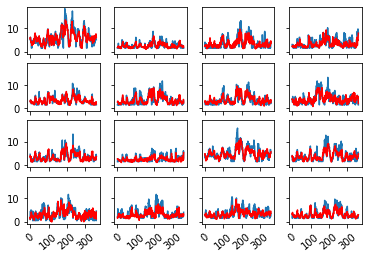

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Convolution2D
from keras.layers import LSTM, SimpleRNN, GRU
import keras as keras
np.random.seed(1234)
from keras import backend as K

class multiLSTM:
    def __init__(self):
        self.inputHorizon = 12 # number of time steps as input
        self.inOutVecDim = 57  # number of stations
        self.lstmModels = [ None for _ in range(6)]
        self.xTest, self.yTest = None, None
        file_dataset = '/content/MS_winds.dat'
        with open(file_dataset) as f:
            data = csv.reader(f, delimiter=",")
            winds = []
            for line in data:
                winds.append((line))
        self.winds = (np.array(winds)).astype(float) # all data
        self.winds = self.winds[:,:self.inOutVecDim]
        self.means_stds = [0,0]
        self.winds, self.means_stds = self.normalize_winds_0_1(self.winds)
        self.validation_split = 0.05
        self.batchSize = 3
        activation = ['sigmoid',   "tanh",   "relu", 'linear']
        self.activation = activation[2]
        realRun = 1
        #          model number :           1   2   3   4   5   6
        self.epochs, self.trainDataRate = [[15, 17, 15, 17, 15, 15], 1] if realRun else [[ 1, 1, 1, 1, 1, 1] , 0.005]# percentage of data used for training(saving time for debuging)

    def normalize_winds_0_1(self, winds):
        '''normalize based on each station data'''
        stations = winds.shape[1]
        normal_winds = []
        mins_maxs = []
        windMax = winds.max()
        windMin = winds.min()
        normal_winds = (winds - windMin) / windMax
        mins_maxs = [windMin, windMax]
        return np.array(normal_winds), mins_maxs

    def denormalize(self, vec):
        res = vec * self.means_stds[1] + self.means_stds[0]        #  fro 0 to 1
        return res

    def loadData_1(self):
        # for lstm1 output xtrain ytrain
        result = []
        for index in range(len(self.winds) - self.inputHorizon):
            result.append(self.winds[index:index + self.inputHorizon])
        result = np.array(result)  

        trainRow = int(6000 * self.trainDataRate)
        X_train = result[:trainRow, :]
        y_train = self.winds[self.inputHorizon:trainRow + self.inputHorizon]
        self.xTest = result[6000:6361, :]
        self.yTest = self.winds[6000 + self.inputHorizon:6361 + self.inputHorizon]
        self.predicted = np.zeros_like(self.yTest)
        return [X_train, y_train]

    def loadData(self, preXTrain, preYTrain, model): # xtrain and ytrain from loadData_1
        # for lstm2 output: xtrain ytrain
        xTrain, yTrain = np.ones_like(preXTrain), np.zeros_like(preYTrain)
  
        for ind in range(len(preXTrain) - self.inputHorizon -1):
            tempInput = preXTrain[ind]
            temp_shape = tempInput.shape
            tempInput = np.reshape(tempInput, (1,temp_shape[0],temp_shape[1]))
            output = model.predict(tempInput)
            tInput = np.reshape(tempInput,temp_shape)
            tempInput = np.vstack((tInput, output))
            tempInput = np.delete(tempInput, 0, axis=0)
            xTrain[ind] = tempInput
            yTrain[ind] = preYTrain[ind+1]
        return [xTrain, yTrain]

  
    def buildModelLSTM_1(self):
        model = Sequential()
        in_nodes = out_nodes = self.inOutVecDim
        layers = [in_nodes, 57*2, 57, 32, out_nodes]
        model.add(LSTM(input_dim=layers[0],units=layers[1],
            return_sequences=False))
    
        model.add(Dense(
            units=layers[4]))
        model.add(Activation(self.activation))
    
        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_2(self):
        model = Sequential()
        layers = [self.inOutVecDim, 10 , 57 * 2, 32, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0],units=layers[1],
            return_sequences=False))

        model.add(Dense(
            units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_3(self):
        model = Sequential()

        layers = [self.inOutVecDim, 57, 57 * 2, 32, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=False))

        model.add(Dense(
            units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_4(self):
        model = Sequential()

        layers = [self.inOutVecDim, 57, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=True))

        model.add(LSTM(layers[2],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_5(self):
        model = Sequential()

        layers = [self.inOutVecDim, 30, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_6(self):
        model = Sequential()
        layers = [self.inOutVecDim, 57*2, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
        return_sequences=True))


        model.add(LSTM(layers[2],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM(self, lstmModelNum):
        if   lstmModelNum == 1:
            return self.buildModelLSTM_1()
        elif lstmModelNum == 2:
            return self.buildModelLSTM_2()
        elif lstmModelNum == 3:
            return self.buildModelLSTM_3()
        elif lstmModelNum == 4:
            return self.buildModelLSTM_4()
        elif lstmModelNum == 5:
            return self.buildModelLSTM_5()
        elif lstmModelNum == 6:
            return self.buildModelLSTM_6()

    def trainLSTM(self, xTrain, yTrain, lstmModelNum):
        # train first LSTM with inputHorizon number of real input values

        lstmModel = self.buildModelLSTM(lstmModelNum)
        lstmModel.fit(xTrain, yTrain, batch_size=self.batchSize, epochs=self.epochs[lstmModelNum-1], validation_split=self.validation_split)
        return lstmModel

    def test(self):
        ''' calculate the predicted values(self.predicted) '''
        for ind in range(len(self.xTest)):
            modelInd = ind % 6
            if modelInd == 0:
                testInputRaw = self.xTest[ind]
                testInputShape = testInputRaw.shape
                testInput = np.reshape(testInputRaw, [1, testInputShape[0], testInputShape[1]])
            else :
                testInputRaw = np.vstack((testInputRaw, self.predicted[ind-1]))
                testInput = np.delete(testInputRaw, 0, axis=0)
                testInputShape = testInput.shape
                testInput = np.reshape(testInput, [1, testInputShape[0], testInputShape[1]])

            self.predicted[ind] = self.lstmModels[modelInd].predict(testInput)

        return

    def errorMeasures(self, denormalYTest, denormalYPredicted):

        mae = np.mean(np.absolute(denormalYTest - denormalYPredicted))
        rmse = np.sqrt((np.mean((np.absolute(denormalYTest - denormalYPredicted)) ** 2)))
        nrsme_maxMin = 100*rmse / (denormalYTest.max() - denormalYTest.min())
        nrsme_mean = 100 * rmse / (denormalYTest.mean())

        return mae, rmse, nrsme_maxMin, nrsme_mean

    def drawGraphStation(self, station, visualise = 1, ax = None ):
        '''draw graph of predicted vs real values'''

        yTest = self.yTest[:, station]
        denormalYTest = self.denormalize(yTest)

        denormalPredicted = self.denormalize(self.predicted[:, station])

        mae, rmse, nrmse_maxMin, nrmse_mean  = self.errorMeasures(denormalYTest, denormalPredicted)
        print( ('station %s : MAE = %7.7s   RMSE = %7.7s    nrmse_maxMin = %7.7s   nrmse_mean = %7.7s'%(station+1, mae, rmse, nrmse_maxMin, nrmse_mean )))

        if visualise:
            if ax is None :
                fig = plt.figure()
                ax = fig.add_subplot(111)

            ax.plot(denormalYTest, label='Real')
            ax.plot(denormalPredicted, label='Predicted', color='red')
            ax.set_xticklabels([0, 100, 200, 300], rotation=40)

        return mae, rmse, nrmse_maxMin, nrmse_mean

    def drawGraphAllStations(self):
        rows, cols = 4, 4
        maeRmse = np.zeros((rows*cols,4))

        fig, ax_array = plt.subplots(rows, cols, sharex=True, sharey=True )
        staInd = 0
        for ax in np.ravel(ax_array):
            maeRmse[staInd] = self.drawGraphStation(staInd, visualise=1, ax=ax)
            staInd += 1
        plt.xticks([0, 100, 200, 300])#, rotation=45)
        errMean = maeRmse.mean(axis=0)
        print( maeRmse.mean(axis=0))

        filename = 'finalEpoch'
        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.show()

        return

    def run(self):
        #  training
        xTrain, yTrain = self.loadData_1()
        print (' Training LSTM 1 ...')
        self.lstmModels[0] = self.trainLSTM(xTrain, yTrain, 1)

        for modelInd in range(1,6):
            xTrain, yTrain = self.loadData(xTrain, yTrain, self.lstmModels[modelInd-1])
            print (' Training LSTM %s ...' % (modelInd+1))
            self.lstmModels[modelInd] = self.trainLSTM(xTrain, yTrain, modelInd+1)

        # testing
        print ('...... TESTING  ...')
        self.test()

        self.drawGraphAllStations()

DeepForecaste = multiLSTM()

DeepForecaste.run()


station 1 : MAE = 1.66394   RMSE = 2.25688    nrmse_maxMin = 13.4265   nrmse_mean = 37.5898
station 2 : MAE = 0.71553   RMSE = 0.96339    nrmse_maxMin = 13.4689   nrmse_mean = 36.8167
station 3 : MAE = 1.29773   RMSE = 1.77609    nrmse_maxMin = 15.1646   nrmse_mean = 50.5377
station 4 : MAE = 1.24743   RMSE = 1.68797    nrmse_maxMin = 19.4621   nrmse_mean = 46.3969
station 5 : MAE = 0.86731   RMSE = 1.18627    nrmse_maxMin = 12.9448   nrmse_mean = 34.3846
station 6 : MAE = 1.07651   RMSE = 1.51098    nrmse_maxMin = 14.8250   nrmse_mean = 42.0866
station 7 : MAE = 1.09197   RMSE = 1.42957    nrmse_maxMin = 14.7361   nrmse_mean = 39.3788
station 8 : MAE = 1.34574   RMSE = 1.79382    nrmse_maxMin = 15.3160   nrmse_mean = 45.7975
station 9 : MAE = 0.90808   RMSE = 1.29753    nrmse_maxMin = 11.0785   nrmse_mean = 37.4966
station 10 : MAE = 0.83503   RMSE = 1.18655    nrmse_maxMin = 21.0654   nrmse_mean = 43.7367
station 11 : MAE = 1.25606   RMSE = 1.74757    nrmse_maxMin = 12.2541   nrmse_m

RuntimeError: ignored

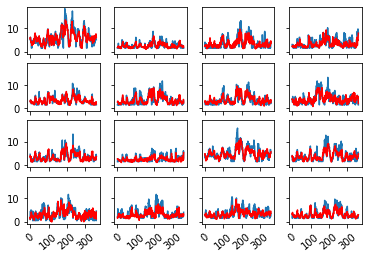

In [ ]:
DeepForecaste.drawGraphAllStations()

In [ ]:
epochs, trainDataRate = [[15, 17, 15, 17, 15, 15], 1] if False else [[ 1, 1, 1, 1, 1, 1] , 0.005]# percentage of data used for training(saving time for debuging)

In [ ]:
trainDataRate

0.005

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended


Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
texlive-latex-recommended set to manually installed.
dvipng is already the newest version (1.15-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super-minimal all 0.3.4-11 [5,810 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pfb2t1c2pfb amd64 0.3

In [ ]:
!apt install dvipng


Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


 Training LSTM 1 ...
Epoch 1/15
3/3 [==============================] - 2s 204ms/step - loss: 0.1280 - val_loss: 0.1491
Epoch 2/15
3/3 [==============================] - 0s 14ms/step - loss: 0.1022 - val_loss: 0.1446
Epoch 3/15
3/3 [==============================] - 0s 13ms/step - loss: 0.0963 - val_loss: 0.1339
Epoch 4/15
3/3 [==============================] - 0s 13ms/step - loss: 0.0951 - val_loss: 0.1307
Epoch 5/15
3/3 [==============================] - 0s 16ms/step - loss: 0.0925 - val_loss: 0.1358
Epoch 6/15
3/3 [==============================] - 0s 12ms/step - loss: 0.0915 - val_loss: 0.1344
Epoch 7/15
3/3 [==============================] - 0s 15ms/step - loss: 0.0905 - val_loss: 0.1350
Epoch 8/15
3/3 [==============================] - 0s 12ms/step - loss: 0.0903 - val_loss: 0.1345
Epoch 9/15
3/3 [==============================] - 0s 12ms/step - loss: 0.0910 - val_loss: 0.1358
Epoch 10/15
3/3 [==============================] - 0s 12ms/step - loss: 0.0898 - val_loss: 0.1294
Epoch 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/li

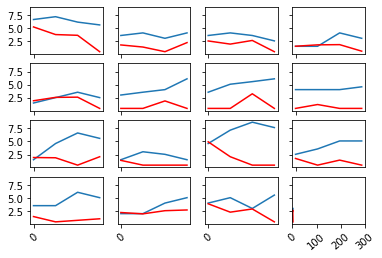

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Convolution2D
from keras.layers import LSTM, SimpleRNN, GRU
import keras as keras
np.random.seed(1234)
from keras import backend as K

class multiLSTM:
    def __init__(self):
        self.inputHorizon = 3 # number of time steps as input
        self.inOutVecDim = 57  # number of stations
        self.lstmModels = [ None for _ in range(6)]
        self.xTest, self.yTest = None, None
        file_dataset = '/content/MS_winds_dummy.dat'
        with open(file_dataset) as f:
            data = csv.reader(f, delimiter=",")
            winds = []
            for line in data:
                winds.append((line))
        self.winds = (np.array(winds)).astype(float) # all data
        self.winds = self.winds[:,:self.inOutVecDim]
        self.means_stds = [0,0]
        self.winds, self.means_stds = self.normalize_winds_0_1(self.winds)
        self.validation_split = 0.05
        self.batchSize = 3
        activation = ['sigmoid',   "tanh",   "relu", 'linear']
        self.activation = activation[2]
        realRun = 1
        #          model number :           1   2   3   4   5   6
        self.epochs, self.trainDataRate = [[15, 17, 15, 17, 15, 15], 1] if realRun else [[ 1, 1, 1, 1, 1, 1] , 0.005]# percentage of data used for training(saving time for debuging)

    def normalize_winds_0_1(self, winds):
        '''normalize based on each station data'''
        stations = winds.shape[1]
        normal_winds = []
        mins_maxs = []
        windMax = winds.max()
        windMin = winds.min()
        normal_winds = (winds - windMin) / windMax
        mins_maxs = [windMin, windMax]
        return np.array(normal_winds), mins_maxs

    def denormalize(self, vec):
        res = vec * self.means_stds[1] + self.means_stds[0]        #  fro 0 to 1
        return res

    def loadData_1(self):
        # for lstm1 output xtrain ytrain
        result = []
        for index in range(len(self.winds) - self.inputHorizon):
            result.append(self.winds[index:index + self.inputHorizon])
        result = np.array(result)  

        trainRow = int(10 * self.trainDataRate)
        X_train = result[:trainRow, :]
        y_train = self.winds[self.inputHorizon:trainRow + self.inputHorizon]
        self.xTest = result[10:14, :]
        self.yTest = self.winds[10 + self.inputHorizon:14 + self.inputHorizon]
        self.predicted = np.zeros_like(self.yTest)
        return [X_train, y_train]

    def loadData(self, preXTrain, preYTrain, model): # xtrain and ytrain from loadData_1
        # for lstm2 output: xtrain ytrain
        xTrain, yTrain = np.ones_like(preXTrain), np.zeros_like(preYTrain)
  
        for ind in range(len(preXTrain) - self.inputHorizon -1):
            tempInput = preXTrain[ind]
            temp_shape = tempInput.shape
            tempInput = np.reshape(tempInput, (1,temp_shape[0],temp_shape[1]))
            output = model.predict(tempInput)
            tInput = np.reshape(tempInput,temp_shape)
            tempInput = np.vstack((tInput, output))
            tempInput = np.delete(tempInput, 0, axis=0)
            xTrain[ind] = tempInput
            yTrain[ind] = preYTrain[ind+1]
        return [xTrain, yTrain]

  
    def buildModelLSTM_1(self):
        model = Sequential()
        in_nodes = out_nodes = self.inOutVecDim
        layers = [in_nodes, 57*2, 57, 32, out_nodes]
        model.add(LSTM(input_dim=layers[0],units=layers[1],
            return_sequences=False))
    
        model.add(Dense(
            units=layers[4]))
        model.add(Activation(self.activation))
    
        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_2(self):
        model = Sequential()
        layers = [self.inOutVecDim, 10 , 57 * 2, 32, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0],units=layers[1],
            return_sequences=False))

        model.add(Dense(
            units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_3(self):
        model = Sequential()

        layers = [self.inOutVecDim, 57, 57 * 2, 32, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=False))

        model.add(Dense(
            units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_4(self):
        model = Sequential()

        layers = [self.inOutVecDim, 57, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=True))

        model.add(LSTM(layers[2],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_5(self):
        model = Sequential()

        layers = [self.inOutVecDim, 30, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_6(self):
        model = Sequential()
        layers = [self.inOutVecDim, 57*2, 57 * 2, 57, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
        return_sequences=True))


        model.add(LSTM(layers[2],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM(self, lstmModelNum):
        if   lstmModelNum == 1:
            return self.buildModelLSTM_1()
        elif lstmModelNum == 2:
            return self.buildModelLSTM_2()
        elif lstmModelNum == 3:
            return self.buildModelLSTM_3()
        elif lstmModelNum == 4:
            return self.buildModelLSTM_4()
        elif lstmModelNum == 5:
            return self.buildModelLSTM_5()
        elif lstmModelNum == 6:
            return self.buildModelLSTM_6()

    def trainLSTM(self, xTrain, yTrain, lstmModelNum):
        # train first LSTM with inputHorizon number of real input values

        lstmModel = self.buildModelLSTM(lstmModelNum)
        lstmModel.fit(xTrain, yTrain, batch_size=self.batchSize, epochs=self.epochs[lstmModelNum-1], validation_split=self.validation_split)
        return lstmModel

    def test(self):
        ''' calculate the predicted values(self.predicted) '''
        for ind in range(len(self.xTest)):
            modelInd = ind % 6
            if modelInd == 0:
                testInputRaw = self.xTest[ind]
                testInputShape = testInputRaw.shape
                testInput = np.reshape(testInputRaw, [1, testInputShape[0], testInputShape[1]])
            else :
                testInputRaw = np.vstack((testInputRaw, self.predicted[ind-1]))
                testInput = np.delete(testInputRaw, 0, axis=0)
                testInputShape = testInput.shape
                testInput = np.reshape(testInput, [1, testInputShape[0], testInputShape[1]])

            self.predicted[ind] = self.lstmModels[modelInd].predict(testInput)

        return

    def errorMeasures(self, denormalYTest, denormalYPredicted):

        mae = np.mean(np.absolute(denormalYTest - denormalYPredicted))
        rmse = np.sqrt((np.mean((np.absolute(denormalYTest - denormalYPredicted)) ** 2)))
        nrsme_maxMin = 100*rmse / (denormalYTest.max() - denormalYTest.min())
        nrsme_mean = 100 * rmse / (denormalYTest.mean())

        return mae, rmse, nrsme_maxMin, nrsme_mean

    def drawGraphStation(self, station, visualise = 1, ax = None ):
        '''draw graph of predicted vs real values'''

        yTest = self.yTest[:, station]
        denormalYTest = self.denormalize(yTest)

        denormalPredicted = self.denormalize(self.predicted[:, station])

        mae, rmse, nrmse_maxMin, nrmse_mean  = self.errorMeasures(denormalYTest, denormalPredicted)
        print( ('station %s : MAE = %7.7s   RMSE = %7.7s    nrmse_maxMin = %7.7s   nrmse_mean = %7.7s'%(station+1, mae, rmse, nrmse_maxMin, nrmse_mean )))

        if visualise:
            if ax is None :
                fig = plt.figure()
                ax = fig.add_subplot(111)

            ax.plot(denormalYTest, label='Real')
            ax.plot(denormalPredicted, label='Predicted', color='red')
            ax.set_xticklabels([0, 100, 200, 300], rotation=40)

        return mae, rmse, nrmse_maxMin, nrmse_mean

    def drawGraphAllStations(self):
        rows, cols = 4, 4
        maeRmse = np.zeros((rows*cols,4))

        fig, ax_array = plt.subplots(rows, cols, sharex=True, sharey=True )
        staInd = 0
        for ax in np.ravel(ax_array):
            maeRmse[staInd] = self.drawGraphStation(staInd, visualise=1, ax=ax)
            staInd += 1
        plt.xticks([0, 100, 200, 300])#, rotation=45)
        errMean = maeRmse.mean(axis=0)
        print( maeRmse.mean(axis=0))

        filename = 'finalEpoch.pdf'
        plt.savefig(filename)
     #   plt.savefig('{}.pgf'.format(filename))
     #   plt.savefig('{}.pdf'.format(filename))
        plt.show()

        return

    def run(self):
        #  training
        xTrain, yTrain = self.loadData_1()
        print (' Training LSTM 1 ...')
        self.lstmModels[0] = self.trainLSTM(xTrain, yTrain, 1)

        for modelInd in range(1,6):
            xTrain, yTrain = self.loadData(xTrain, yTrain, self.lstmModels[modelInd-1])
            print (' Training LSTM %s ...' % (modelInd+1))
            self.lstmModels[modelInd] = self.trainLSTM(xTrain, yTrain, modelInd+1)

        # testing
        print ('...... TESTING  ...')
        self.test()

        self.drawGraphAllStations()

DeepForecaste = multiLSTM()
DeepForecaste.run()


In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
d = "7.1526,3.5763,3.0399,4.0681,1.5199,4.0681,4.6045,2.0564,4.6045,4.0681,2.5481,3.5763,2.0564,2.5481,5.588,2.5481,1.5199,0,5.588,4.0681,6.1244,6.1244,9.1643,7.1526,3.5763,5.588,4.6045,3.5763,4.0681,2.5481,4.0681,2.5481,8.1361,3.0399,1.5199,7.6444,2.0564,5.0963,5.0963,3.5763,3.5763,9.7008,3.5763,8.1361,3.5763,3.5763,6.1244,2.5481,3.0399,4.6045,4.6045,2.0564,2.0564,4.6045,4.0681,0,4.6045".split(",")

In [ ]:
len(d)

57

In [ ]:
import pandas as pd

In [ ]:
df20 = pd.read_csv("daily20.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df20 = df20[['day','avg_wind_speed_kts']]

In [ ]:
df20 = df20[df20["avg_wind_speed_kts"] != "None"]

In [ ]:
df = pd.read_csv("daily.csv")

In [ ]:
df = df[['day','avg_wind_speed_kts']]

In [ ]:
df = df[df["avg_wind_speed_kts"] != "None"]

In [ ]:
df2 = pd.DataFrame(columns = col_list)


In [ ]:
col_list = [str(x) for x in range(1,40)]


In [ ]:
df2[df2.iloc[:,1].name]

Series([], Name: s2, dtype: object)

In [ ]:
df2.columns

Index(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21',
       's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31',
       's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39'],
      dtype='object')

In [ ]:
df.groupby(by=df['day']).sum().iloc[0]

avg_wind_speed_kts    6.04347856.6521744.08695653.26086956.8695655.3...
Name: 2018-01-01, dtype: object

In [ ]:
df['NewColumn'] = df.apply(lambda x: ', '.join(x[x.str.contains('abc')]), axis=1)
print (df)

In [ ]:
df2["Date"] = df["day"]

In [ ]:
df2["windspeed"] = df["avg_wind_speed_kts"]

In [ ]:
df2

,1,2,3,4,5,6,7,8,9,10,...,32,33,34,35,36,37,38,39,Date,windspeed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,6.0434785
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,6.652174
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,4.0869565
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,3.2608695
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,6.869565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01,5.826087
42779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01,7.304348
42780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01,2.3521738
42781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01,5.222944


In [ ]:
df["day"].value_counts()

2019-07-03    39
2019-05-27    39
2020-07-09    39
2020-07-08    39
2020-07-07    39
              ..
2019-10-19    36
2019-10-26    36
2018-06-30    36
2018-02-21    32
2018-08-21    25
Name: day, Length: 1097, dtype: int64

In [ ]:
df.hr

In [ ]:
k=1
d=0
for i in range(len(df2)-1):
  if (df2["Date"][i] == df2["Date"][i+1]):
    df2[str(k)][d] = df2["windspeed"][i]
    k += 1
  else:
    d += 1
  if k>=39:
    k=1

In [ ]:
df2.reset_index(inplace = True,drop = True)

In [ ]:
df3 = df2.iloc[:1097]

In [ ]:
df.groupby(df["day"]).sum()

,avg_wind_speed_kts
day,
2018-01-01,6.04347856.6521744.08695653.26086956.8695655.3...
2018-01-02,5.91304355.698550712.5318848.05797112.3043482....
2018-01-03,5.43478256.43478256.02.79803664.5217396.608695...
2018-01-04,6.409259311.6869568.224867.92101437.0036237.50...
2018-01-05,11.36666711.2173916.95652155.91853953.95652172...
...,...
2020-12-28,5.56521756.4782617.08695656.73913057.27898557....
2020-12-29,14.4782614.39855053.1584239.1796295.329718.728...
2020-12-30,6.6956524.01.73913045.8260878.9565228.9130437....


In [ ]:
df4 = df3.drop(columns="39")

In [ ]:
df4 = df4.fillna(method="backfill")

In [ ]:
df4

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,Date,windspeed
0,6.0434785,6.652174,4.0869565,3.2608695,6.869565,5.347826,2.5217392,11.173913,11.695652,4.304348,...,7.611111,6.5876436,10.391304,6.0,7.4347825,2.286232,5.9130435,5.6985507,2018-01-01,6.0434785
1,12.531884,8.057971,12.304348,2.7391305,6.4944444,12.718841,7.181818,13.434783,5.902174,11.782609,...,14.565217,7.826087,5.478261,9.217391,5.4347825,6.4347825,5.9130435,5.6985507,2018-01-01,6.652174
2,4.521739,6.6086955,3.0434783,3.3913043,7.826087,6.130435,4.478261,6.5467052,5.0869565,6.7391305,...,6.2608695,6.442967,4.674074,6.4092593,5.4347825,6.4347825,6.0,2.7980366,2018-01-01,4.0869565
3,7.5086956,8.173913,7.2431817,11.394203,10.068116,5.521739,1.3478261,7.478261,7.226081,10.043478,...,5.478261,6.347826,11.366667,6.4092593,11.686956,8.22486,7.9210143,7.003623,2018-01-01,3.2608695
4,7.0869565,5.9565215,15.304348,6.478261,9.434783,8.422463,13.086957,10.478261,5.173913,15.391304,...,11.130435,8.218926,11.366667,11.217391,6.9565215,5.9185395,3.9565217,2.173913,2018-01-01,6.869565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,7.9565215,9.530435,3.6956522,3.6817539,6.0434785,7.478261,9.173913,5.4123187,7.5304346,8.471739,...,8.37971,12.565217,12.26087,3.652174,10.826087,8.652174,9.211595,7.7391305,2018-01-29,7.6086955
1093,4.8768115,8.73913,7.9565215,5.521739,12.434783,6.6086955,2.9565217,4.173913,3.347826,1.5652174,...,9.565217,14.304348,5.869565,6.826087,4.130435,12.913043,10.434783,13.043478,2018-01-29,3.3782609
1094,2.9565217,2.24189,3.5652175,6.521739,8.478261,4.7391305,2.5652175,7.0555553,4.4869566,2.6657302,...,1.9130435,4.347826,7.2608695,7.2608695,7.7753625,0.65217394,2.5217392,8.391304,2018-01-29,10.73913
1095,0.7826087,4.7391305,4.0869565,5.4347825,5.652174,1.9565217,5.130435,6.3746376,3.5652175,1.6956521,...,1.6956521,3.0869565,2.347826,3.2608695,6.0434785,1.826087,3.0833333,3.3043478,2018-01-29,6.347826


In [ ]:
df.head(50)


,day,avg_wind_speed_kts
0,2018-01-01,6.0434785
1,2018-01-01,6.652174
2,2018-01-01,4.0869565
3,2018-01-01,3.2608695
4,2018-01-01,6.869565
5,2018-01-01,5.347826
6,2018-01-01,2.5217392
7,2018-01-01,11.173913
8,2018-01-01,11.695652
9,2018-01-01,4.304348


In [ ]:
31%39

31

In [ ]:
df

,day,avg_wind_speed_kts
0,2018-01-01,6.0434785
1,2018-01-01,6.652174
2,2018-01-01,4.0869565
3,2018-01-01,3.2608695
4,2018-01-01,6.869565
...,...,...
7529,2018-07-13,3.1111112
7530,2018-07-13,6.0434785
7531,2018-07-13,6.676087
7532,2018-07-13,6.039855


In [ ]:
dfx=df.groupby('day').agg({'avg_wind_speed_kts':list})
print(dfx)

                                           avg_wind_speed_kts
day                                                          
2018-01-01  [6.0434785, 6.652174, 4.0869565, 3.2608695, 6....
2018-01-02  [5.9130435, 5.6985507, 12.531884, 8.057971, 12...
2018-01-03  [5.4347825, 6.4347825, 6.0, 2.7980366, 4.52173...
2018-01-04  [6.4092593, 11.686956, 8.22486, 7.9210143, 7.0...
2018-01-05  [11.366667, 11.217391, 6.9565215, 5.9185395, 3...
...                                                       ...
2018-07-09  [5.035507, 4.45, 8.0, 6.0813465, 12.347101, 4....
2018-07-10  [5.304348, 2.6086957, 9.173913, 9.913043, 11.1...
2018-07-11  [16.27174, 6.0454545, 12.047826, 8.933333, 4.4...
2018-07-12  [4.347826, 6.2608695, 7.4347825, 6.9130435, 6....
2018-07-13  [5.0107527, 7.686525, 3.1111112, 6.0434785, 6....

[194 rows x 1 columns]


In [ ]:
final = pd.DataFrame(dfx['avg_wind_speed_kts'].tolist(),index=dfx.index).add_prefix("s")


                   s0         s1         s2         s3         s4         s5  \
day                                                                            
2018-01-01  6.0434785   6.652174  4.0869565  3.2608695   6.869565   5.347826   
2018-01-02  5.9130435  5.6985507  12.531884   8.057971  12.304348  2.7391305   
2018-01-03  5.4347825  6.4347825        6.0  2.7980366   4.521739  6.6086955   
2018-01-04  6.4092593  11.686956    8.22486  7.9210143   7.003623  7.5086956   
2018-01-05  11.366667  11.217391  6.9565215  5.9185395  3.9565217   2.173913   
...               ...        ...        ...        ...        ...        ...   
2018-07-09   5.035507       4.45        8.0  6.0813465  12.347101  4.9175925   
2018-07-10   5.304348  2.6086957   9.173913   9.913043  11.131241  7.7826085   
2018-07-11   16.27174  6.0454545  12.047826   8.933333  4.4072466  10.701449   
2018-07-12   4.347826  6.2608695  7.4347825  6.9130435  6.5434785  5.2608695   
2018-07-13  5.0107527   7.686525  3.1111

In [ ]:
dfx2=df20.groupby('day').agg({'avg_wind_speed_kts':list})
print(dfx2)

                                           avg_wind_speed_kts
day                                                          
2011-01-01  [4.5652175, 8.695652, 4.2874045, 0.7826087, 6....
2011-01-02  [10.391304, 2.1304348, 11.782609, 5.347826, 3....
2011-01-03  [4.041304, 7.772464, 1.5217391, 1.589394, 7.43...
2011-01-04  [4.4347825, 7.826087, 10.956522, 13.869565, 14...
2011-01-05  [4.160145, 3.575, 8.053623, 4.821545, 2.216748...
...                                                       ...
2015-05-04  [6.3507247, 8.273913, 6.2608695, 5.521739, 11....
2015-05-05  [7.5652175, 10.956522, 16.391304, 9.912104, 12...
2015-05-06  [8.173913, 10.73913, 11.456704, 12.521739, 13....
2015-05-07  [6.444697, 12.599276, 14.622464, 15.043478, 5....
2015-05-08  [4.347826, 6.173913, 5.3913045, 5.0434785, 2.9...

[1589 rows x 1 columns]


In [ ]:
final2 = pd.DataFrame(dfx2['avg_wind_speed_kts'].tolist(),index=dfx2.index).add_prefix("s")

In [ ]:
final3 = final2.drop(columns=["s37","s38"])

In [ ]:
final3.dropna(inplace=True)

In [ ]:
final3.drop

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s27,s28,s29,s30,s31,s32,s33,s34,s35,s36
day,,,,,,,,,,,,,,,,,,,,,
2011-01-01,4.5652175,8.695652,4.2874045,0.7826087,6.130435,2.4347825,4.826087,6.2608695,6.304348,10.26087,...,2.5,7.061826,13.086835,2.0869565,3.0869565,3.173913,5.652174,5.4347825,6.5652175,2.3913043
2011-01-02,10.391304,2.1304348,11.782609,5.347826,3.5217392,4.526087,5.695652,5.6086955,3.2089763,2.9746377,...,8.869565,10.826087,9.826087,6.2173915,12.923345,6.636107,4.80942,4.6886363,1.5166667,7.521739
2011-01-03,4.041304,7.772464,1.5217391,1.589394,7.4347825,4.9130435,14.206522,6.869565,4.031735,5.0869565,...,6.637681,5.964493,7.776087,8.628006,7.130435,4.9565215,8.130435,12.0,7.5652175,8.869565
2011-01-04,4.4347825,7.826087,10.956522,13.869565,14.130435,9.086957,13.826087,8.956522,8.086957,2.4347825,...,5.4347825,3.9565217,1.8695652,4.695652,8.261084,2.9550724,2.4710398,6.5977573,7.2449265,4.1457605
2011-01-05,4.160145,3.575,8.053623,4.821545,2.2167487,7.791304,3.7733612,6.9130435,3.1347826,14.048551,...,4.3913045,3.2608695,8.173913,3.4934783,5.130435,2.652174,7.652174,4.7391305,2.826087,12.26087


In [ ]:
final3.to_csv('saskDaily', index=False, header=False)

In [ ]:
final3.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s27,s28,s29,s30,s31,s32,s33,s34,s35,s36
day,,,,,,,,,,,,,,,,,,,,,
2011-01-01,4.5652175,8.695652,4.2874045,0.7826087,6.130435,2.4347825,4.826087,6.2608695,6.304348,10.26087,...,2.5,7.061826,13.086835,2.0869565,3.0869565,3.173913,5.652174,5.4347825,6.5652175,2.3913043
2011-01-02,10.391304,2.1304348,11.782609,5.347826,3.5217392,4.526087,5.695652,5.6086955,3.2089763,2.9746377,...,8.869565,10.826087,9.826087,6.2173915,12.923345,6.636107,4.80942,4.6886363,1.5166667,7.521739
2011-01-03,4.041304,7.772464,1.5217391,1.589394,7.4347825,4.9130435,14.206522,6.869565,4.031735,5.0869565,...,6.637681,5.964493,7.776087,8.628006,7.130435,4.9565215,8.130435,12.0,7.5652175,8.869565
2011-01-04,4.4347825,7.826087,10.956522,13.869565,14.130435,9.086957,13.826087,8.956522,8.086957,2.4347825,...,5.4347825,3.9565217,1.8695652,4.695652,8.261084,2.9550724,2.4710398,6.5977573,7.2449265,4.1457605
2011-01-05,4.160145,3.575,8.053623,4.821545,2.2167487,7.791304,3.7733612,6.9130435,3.1347826,14.048551,...,4.3913045,3.2608695,8.173913,3.4934783,5.130435,2.652174,7.652174,4.7391305,2.826087,12.26087


In [ ]:
final4 = pd.read_csv("/content/saskDaily")

In [ ]:
final4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   4.5652175   1572 non-null   float64
 1   8.695652    1572 non-null   float64
 2   4.2874045   1572 non-null   float64
 3   0.7826087   1572 non-null   float64
 4   6.130435    1572 non-null   float64
 5   2.4347825   1572 non-null   float64
 6   4.826087    1572 non-null   float64
 7   6.2608695   1572 non-null   float64
 8   6.304348    1572 non-null   float64
 9   10.26087    1572 non-null   float64
 10  8.217391    1572 non-null   float64
 11  3.7391305   1572 non-null   float64
 12  7.347826    1572 non-null   float64
 13  6.7826085   1572 non-null   float64
 14  10.304348   1572 non-null   float64
 15  7.9130435   1572 non-null   float64
 16  4.612319    1572 non-null   float64
 17  3.2847826   1572 non-null   float64
 18  7.0340424   1572 non-null   float64
 19  2.4586627   1572 non-null  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
import sys
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Convolution2D
from keras.layers import LSTM, SimpleRNN, GRU
import keras as keras
np.random.seed(1234)
from keras import backend as K

class multiLSTM:
    def __init__(self):
        self.inputHorizon = 12 # number of time steps as input
        self.inOutVecDim = 37  # number of stations
        self.lstmModels = [ None for _ in range(6)]
        self.xTest, self.yTest = None, None
        file_dataset = '/content/saskDaily'
        with open(file_dataset) as f:
            data = csv.reader(f, delimiter=",")
            winds = []
            for line in data:
                winds.append((line))
        self.winds = (np.array(winds)).astype(float) # all data
        self.winds = self.winds[:,:self.inOutVecDim]
        self.means_stds = [0,0]
        self.winds, self.means_stds = self.normalize_winds_0_1(self.winds)
        self.validation_split = 0.05
        self.batchSize = 3
        activation = ['sigmoid',   "tanh",   "relu", 'linear']
        self.activation = activation[2]
        realRun = 1
        #          model number :           1   2   3   4   5   6
        self.epochs, self.trainDataRate = [[15, 17, 15, 17, 15, 15], 1] if realRun else [[ 1, 1, 1, 1, 1, 1] , 0.005]# percentage of data used for training(saving time for debuging)

    def normalize_winds_0_1(self, winds):
        '''normalize based on each station data'''
        stations = winds.shape[1]
        normal_winds = []
        mins_maxs = []
        windMax = winds.max()
        windMin = winds.min()
        normal_winds = (winds - windMin) / windMax
        mins_maxs = [windMin, windMax]
        return np.array(normal_winds), mins_maxs

    def denormalize(self, vec):
        res = vec * self.means_stds[1] + self.means_stds[0]        #  fro 0 to 1
        return res

    def loadData_1(self):
        # for lstm1 output xtrain ytrain
        result = []
        for index in range(len(self.winds) - self.inputHorizon):
            result.append(self.winds[index:index + self.inputHorizon])
        result = np.array(result)  

        trainRow = int(1100 * self.trainDataRate)
        X_train = result[:trainRow, :]
        y_train = self.winds[self.inputHorizon:trainRow + self.inputHorizon]
        self.xTest = result[1100:1200, :]
        self.yTest = self.winds[6000 + self.inputHorizon:1200 + self.inputHorizon]
        self.predicted = np.zeros_like(self.yTest)
        return [X_train, y_train]

    def loadData(self, preXTrain, preYTrain, model): # xtrain and ytrain from loadData_1
        # for lstm2 output: xtrain ytrain
        xTrain, yTrain = np.ones_like(preXTrain), np.zeros_like(preYTrain)
  
        for ind in range(len(preXTrain) - self.inputHorizon -1):
            tempInput = preXTrain[ind]
            temp_shape = tempInput.shape
            tempInput = np.reshape(tempInput, (1,temp_shape[0],temp_shape[1]))
            output = model.predict(tempInput)
            tInput = np.reshape(tempInput,temp_shape)
            tempInput = np.vstack((tInput, output))
            tempInput = np.delete(tempInput, 0, axis=0)
            xTrain[ind] = tempInput
            yTrain[ind] = preYTrain[ind+1]
        return [xTrain, yTrain]

  
    def buildModelLSTM_1(self):
        model = Sequential()
        in_nodes = out_nodes = self.inOutVecDim
        layers = [in_nodes, 37*2, 37, 32, out_nodes]
        model.add(LSTM(input_dim=layers[0],units=layers[1],
            return_sequences=False))
    
        model.add(Dense(
            units=layers[4]))
        model.add(Activation(self.activation))
    
        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_2(self):
        model = Sequential()
        layers = [self.inOutVecDim, 10 , 37 * 2, 32, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0],units=layers[1],
            return_sequences=False))

        model.add(Dense(
            units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_3(self):
        model = Sequential()

        layers = [self.inOutVecDim, 37, 37 * 2, 32, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=False))

        model.add(Dense(
            units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_4(self):
        model = Sequential()

        layers = [self.inOutVecDim, 37, 37 * 2, 37, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=True))

        model.add(LSTM(layers[2],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_5(self):
        model = Sequential()

        layers = [self.inOutVecDim, 30, 37 * 2, 37, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM_6(self):
        model = Sequential()
        layers = [self.inOutVecDim, 37*2, 37 * 2, 37, self.inOutVecDim]
        model.add(LSTM(input_dim=layers[0], units=layers[1],
        return_sequences=True))


        model.add(LSTM(layers[2],
            return_sequences=False))

        model.add(Dense(units=layers[4]))

        model.add(Activation(self.activation))

        optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(loss="mae", optimizer=optimizer)

        return model

    def buildModelLSTM(self, lstmModelNum):
        if   lstmModelNum == 1:
            return self.buildModelLSTM_1()
        elif lstmModelNum == 2:
            return self.buildModelLSTM_2()
        elif lstmModelNum == 3:
            return self.buildModelLSTM_3()
        elif lstmModelNum == 4:
            return self.buildModelLSTM_4()
        elif lstmModelNum == 5:
            return self.buildModelLSTM_5()
        elif lstmModelNum == 6:
            return self.buildModelLSTM_6()

    def trainLSTM(self, xTrain, yTrain, lstmModelNum):
        # train first LSTM with inputHorizon number of real input values

        lstmModel = self.buildModelLSTM(lstmModelNum)
        lstmModel.fit(xTrain, yTrain, batch_size=self.batchSize, epochs=self.epochs[lstmModelNum-1], validation_split=self.validation_split)
        return lstmModel

    def test(self):
        ''' calculate the predicted values(self.predicted) '''
        for ind in range(len(self.xTest)):
            modelInd = ind % 6
            if modelInd == 0:
                testInputRaw = self.xTest[ind]
                testInputShape = testInputRaw.shape
                testInput = np.reshape(testInputRaw, [1, testInputShape[0], testInputShape[1]])
            else :
                testInputRaw = np.vstack((testInputRaw, self.predicted[ind-1]))
                testInput = np.delete(testInputRaw, 0, axis=0)
                testInputShape = testInput.shape
                testInput = np.reshape(testInput, [1, testInputShape[0], testInputShape[1]])

            self.predicted[ind] = self.lstmModels[modelInd].predict(testInput)

        return

    def errorMeasures(self, denormalYTest, denormalYPredicted):

        mae = np.mean(np.absolute(denormalYTest - denormalYPredicted))
        rmse = np.sqrt((np.mean((np.absolute(denormalYTest - denormalYPredicted)) ** 2)))
        nrsme_maxMin = 100*rmse / (denormalYTest.max() - denormalYTest.min())
        nrsme_mean = 100 * rmse / (denormalYTest.mean())

        return mae, rmse, nrsme_maxMin, nrsme_mean

    def drawGraphStation(self, station, visualise = 1, ax = None ):
        '''draw graph of predicted vs real values'''

        yTest = self.yTest[:, station]
        denormalYTest = self.denormalize(yTest)

        denormalPredicted = self.denormalize(self.predicted[:, station])

        mae, rmse, nrmse_maxMin, nrmse_mean  = self.errorMeasures(denormalYTest, denormalPredicted)
        print( ('station %s : MAE = %7.7s   RMSE = %7.7s    nrmse_maxMin = %7.7s   nrmse_mean = %7.7s'%(station+1, mae, rmse, nrmse_maxMin, nrmse_mean )))

        if visualise:
            if ax is None :
                fig = plt.figure()
                ax = fig.add_subplot(111)

            ax.plot(denormalYTest, label='Real')
            ax.plot(denormalPredicted, label='Predicted', color='red')
            ax.set_xticklabels([0, 100, 200, 300], rotation=40)

        return mae, rmse, nrmse_maxMin, nrmse_mean

    def drawGraphAllStations(self):
        rows, cols = 4, 4
        maeRmse = np.zeros((rows*cols,4))

        fig, ax_array = plt.subplots(rows, cols, sharex=True, sharey=True )
        staInd = 0
        for ax in np.ravel(ax_array):
            maeRmse[staInd] = self.drawGraphStation(staInd, visualise=1, ax=ax)
            staInd += 1
        plt.xticks([0, 100, 200, 300])#, rotation=45)
        errMean = maeRmse.mean(axis=0)
        print( maeRmse.mean(axis=0))

        filename = 'finalEpoch'
        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.show()

        return

    def run(self):
        #  training
        xTrain, yTrain = self.loadData_1()
        print (' Training LSTM 1 ...')
        self.lstmModels[0] = self.trainLSTM(xTrain, yTrain, 1)

        for modelInd in range(1,6):
            xTrain, yTrain = self.loadData(xTrain, yTrain, self.lstmModels[modelInd-1])
            print (' Training LSTM %s ...' % (modelInd+1))
            self.lstmModels[modelInd] = self.trainLSTM(xTrain, yTrain, modelInd+1)

        # testing
        print ('...... TESTING  ...')
        self.test()

        self.drawGraphAllStations()

DeepForecaste = multiLSTM()

DeepForecaste.run()


 Training LSTM 1 ...
Epoch 1/15
349/349 [==============================] - 9s 5ms/step - loss: 0.1350 - val_loss: 0.1468
Epoch 2/15
349/349 [==============================] - 2s 4ms/step - loss: 0.1287 - val_loss: 0.1455
Epoch 3/15
349/349 [==============================] - 1s 4ms/step - loss: 0.1281 - val_loss: 0.1407
Epoch 4/15
349/349 [==============================] - 2s 4ms/step - loss: 0.1233 - val_loss: 0.1347
Epoch 5/15
349/349 [==============================] - 1s 4ms/step - loss: 0.1194 - val_loss: 0.1336
Epoch 6/15
349/349 [==============================] - 1s 4ms/step - loss: 0.1193 - val_loss: 0.1328
Epoch 7/15
349/349 [==============================] - 2s 4ms/step - loss: 0.1189 - val_loss: 0.1343
Epoch 8/15
349/349 [==============================] - 1s 4ms/step - loss: 0.1187 - val_loss: 0.1357
Epoch 9/15
349/349 [==============================] - 2s 4ms/step - loss: 0.1187 - val_loss: 0.1365
Epoch 10/15
349/349 [==============================] - 2s 4ms/step - loss: 0.11